<a href="https://colab.research.google.com/github/shamsakhoja7-max/msba-portfolio-shamsakhoja/blob/main/TRUSOURCE_CB_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

telco_df2 = pd.read_excel('/content/drive/MyDrive/Class - PA/churn_df_data_2 (1).xlsx')

Mounted at /content/drive


Step 1: Partition our Data and Pre-processing.

In [ ]:
### For classification problems, first determine the classes of your response variable
print(telco_df2["left_flag"].dtype)
print(telco_df2["left_flag"].unique())

object
['No' 'Yes']


In [ ]:
Y = (telco_df2["left_flag"] == "Yes") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1

X = telco_df2.drop(columns=["left_flag"])


In [ ]:
Y.unique() #check if this was done

array([False,  True])

In [ ]:
X.columns #check if this was done

Index(['has_dependents', 'tenure_mo', 'home_phone', 'multi_line',
       'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee',
       'total_billed', 'gender', 'age_years', 'is_married', 'recent_offer',
       'avg_long_dist_fee', 'internet_tech', 'avg_gb_download',
       'unlimited_data_opt', 'extra_data_fees_total', 'long_dist_fees_total',
       'num_add_ons', 'has_add_on', 'has_streaming', 'is_referrer',
       'received_refund', 'overage_ratio', 'unexpected_cost_burden'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 26), (1691, 26))

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


Trying another catboost

In [ ]:
print(type(y_train))
print(getattr(y_train, "shape", None))


<class 'pandas.core.series.Series'>
(3945,)


In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

cat_cols = ['has_dependents',
 'home_phone',
 'multi_line',
 'contract_term',
 'e_bill_opt_in',
 'pay_method',
 'gender',
 'is_married',
 'recent_offer',
 'internet_tech',
 'unlimited_data_opt']  # categorical column names in your X DataFrame

cat_pipe = Pipeline([
    ("model", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=99,
        verbose=0,                # keeps output quiet for students
        allow_writing_files=False # avoids CatBoost creating extra files
    ))
])

param_grid = {
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.01, 0.03],
    "model__iterations": [400, 800],
    "model__l2_leaf_reg": [1, 3, 10],

}

cat_cv = GridSearchCV(
    estimator=cat_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    return_train_score=True # checking training score
)

# This is the key line: pass cat_features at FIT time
cat_cv.fit(X_train, y_train, model__cat_features=cat_cols)

best_model = cat_cv.best_estimator_
print(cat_cv.best_params_)


{'model__depth': 4, 'model__iterations': 400, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.03}


In [ ]:
from sklearn.metrics import roc_auc_score

best_model = cat_cv.best_estimator_   # pipeline with ("model", CatBoostClassifier)


#printing both AUC (Training and Validation to check the AUC stability)
cv_results = pd.DataFrame(cat_cv.cv_results_)
best_idx = cat_cv.best_index_

# ✅ Training + Validation AUC (from CV)
print(f"Training AUC (CV avg):   {cv_results.loc[best_idx, 'mean_train_score']:.3f}")
print(f"Validation AUC (CV avg): {cv_results.loc[best_idx, 'mean_test_score']:.3f}")


y_test_proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(Y_test, y_test_proba)
print(f"CatBoost (tuned) Test AUC: {auc:.3f}")


Training AUC (CV avg):   0.887
Validation AUC (CV avg): 0.847
CatBoost (tuned) Test AUC: 0.848


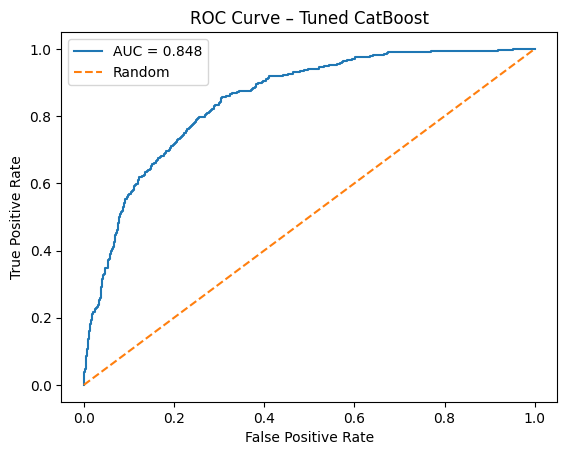

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(Y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Tuned CatBoost")
plt.legend()
plt.show()


Test PR-AUC: 0.6733


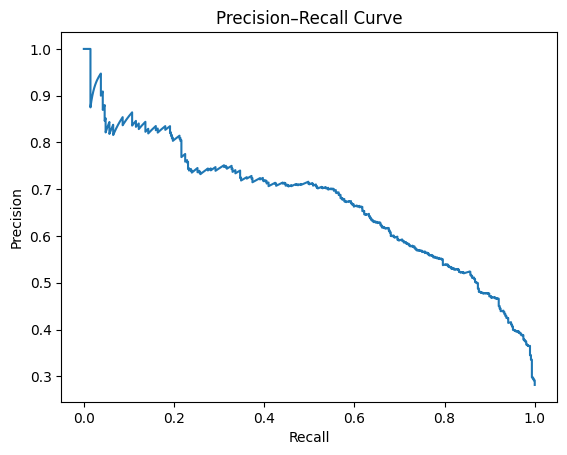

In [ ]:
#precision

from sklearn.metrics import average_precision_score

pr_auc = average_precision_score(Y_test, y_test_proba)
print("Test PR-AUC:", round(pr_auc, 4))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(Y_test, y_test_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

In [ ]:

import pandas as pd

cb = best_model.named_steps["model"]   # CatBoostClassifier
importances = cb.get_feature_importance()  # default = PredictionValuesChange

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
4,contract_term,17.725894
7,monthly_fee,13.420334
1,tenure_mo,12.307928
14,internet_tech,7.823404
19,num_add_ons,5.685416
6,pay_method,4.705879
8,total_billed,4.637592
10,age_years,4.495856
15,avg_gb_download,4.219391
18,long_dist_fees_total,3.567208


In [ ]:
best_model.named_steps.keys()

dict_keys(['model'])

In [ ]:
import matplotlib.pyplot as plt
from catboost import Pool

# 1) Get best fitted CatBoost model from GridSearchCV pipeline (only step is 'model')
best_cb = cat_cv.best_estimator_.named_steps["model"]

# 2) Choose your SHAP dataset (sample for speed, optional)
X_shap = X_test.copy()
X_shap = X_shap.sample(min(1000, len(X_shap)), random_state=42)

# 3) Tell CatBoost which columns are categorical (prevents "Yes" -> float error)
cat_cols = X_shap.select_dtypes(include=["object", "category"]).columns.tolist()

pool = Pool(X_shap, cat_features=cat_cols)

# 4) CatBoost-native SHAP values
shap_vals = best_cb.get_feature_importance(pool, type="ShapValues")

# shap_vals shape = (n_rows, n_features + 1). Last column = expected value
shap_values = shap_vals[:, :-1]

# 5) Mean(|SHAP|) feature importance
imp = pd.Series(np.abs(shap_values).mean(axis=0), index=X_shap.columns).sort_values(ascending=False)

display(imp.head(20))



,0
contract_term,0.608607
tenure_mo,0.374471
monthly_fee,0.323017
pay_method,0.281363
internet_tech,0.245464
num_add_ons,0.173917
has_streaming,0.126723
e_bill_opt_in,0.115152
total_billed,0.114297
long_dist_fees_total,0.112341


#Longer bar - more influence

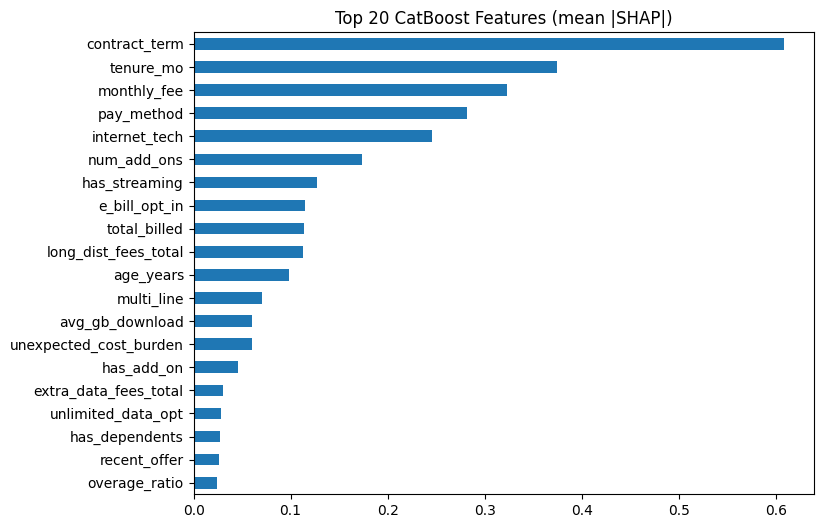

In [ ]:

# 6) Plot top 10
plt.figure(figsize=(8, 6))
imp.head(20).sort_values().plot(kind="barh", legend=False)
plt.title("Top 20 CatBoost Features (mean |SHAP|)")
plt.show()

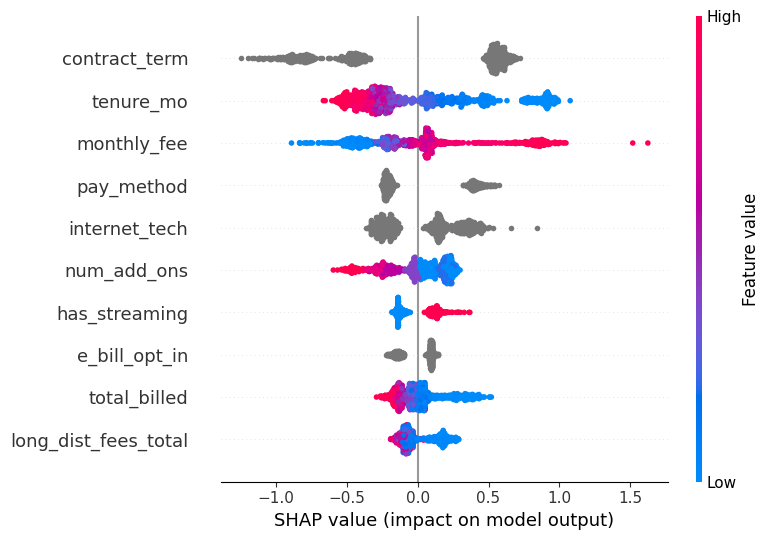

In [ ]:
import shap

shap.summary_plot(shap_values, X_shap, max_display=10, show=True)


In [ ]:
import numpy as np
import shap

assert shap_values.shape[1] == X_shap.shape[1], "Mismatch: shap_values columns != X_shap columns"


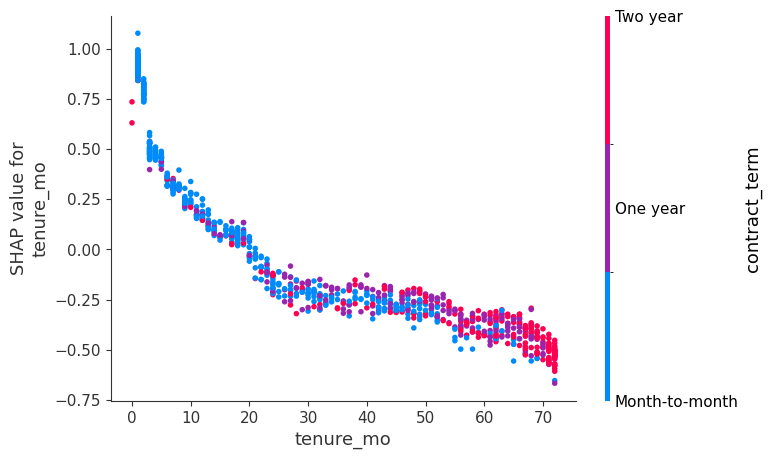

In [ ]:
shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="contract_term",
    show=True
)

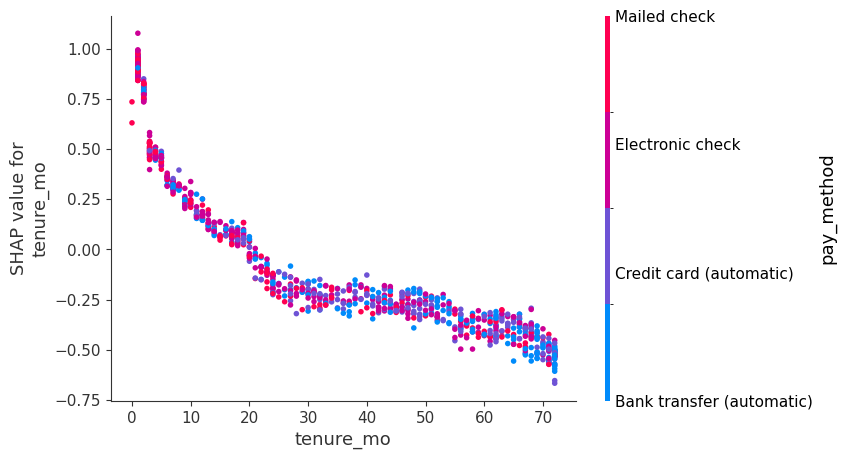

In [ ]:
shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="pay_method",
    show=True
)

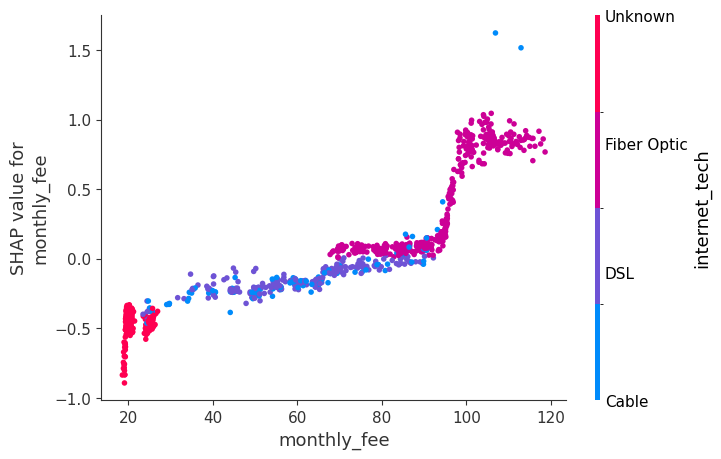

In [ ]:
shap.dependence_plot(
    "monthly_fee",
    shap_values,
    X_shap,
    interaction_index="internet_tech",
    show=True
)

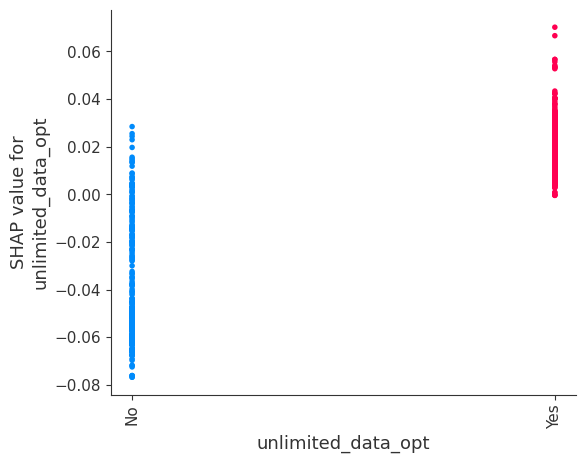

In [ ]:
shap.dependence_plot(
    "unlimited_data_opt",
    shap_values,
    X_shap,
    interaction_index="unlimited_data_opt",
    show=True
)

# why catboost
- ordered boosting which prevents leakage
- leading to More stable AUC
- preseves behaviour signals from categorical variables which are lost in one-hot coding due to sparse data in some columns.
- For churn data this can reveal customer behavior insights

#plots for recommendations

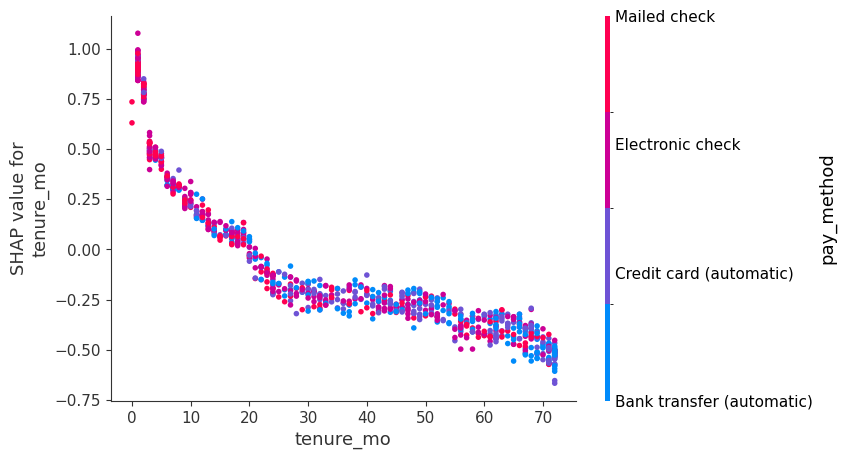

In [ ]:
import matplotlib.pyplot as plt
import shap

shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="pay_method",
    show=False
)





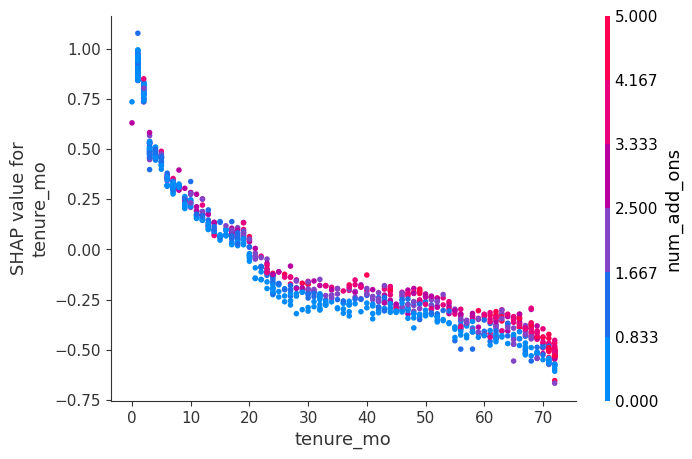

In [ ]:
shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="num_add_ons",
    show=True
)

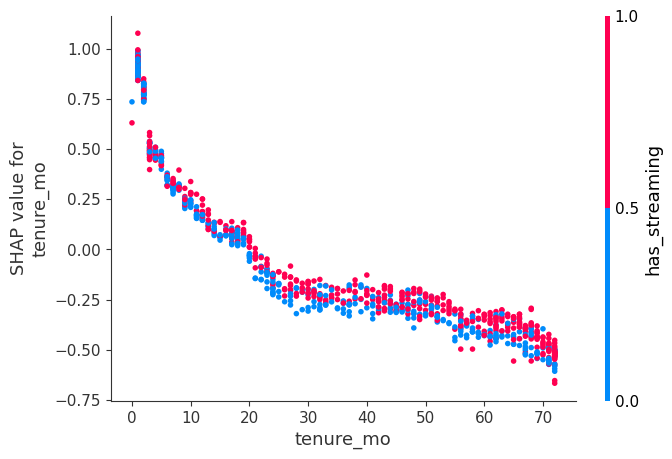

In [ ]:
shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="has_streaming",
    show=True
)

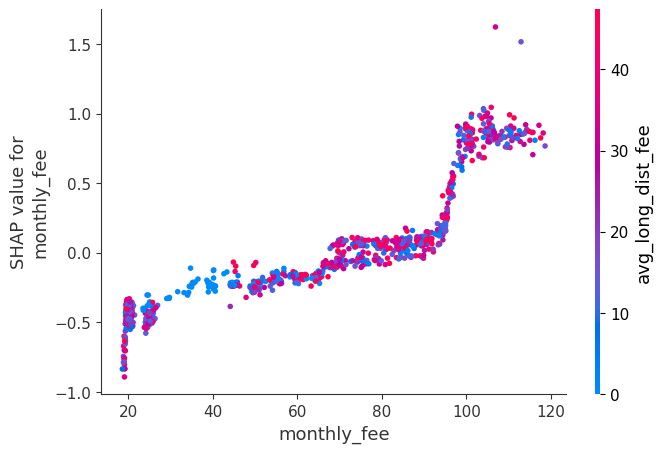

In [ ]:
shap.dependence_plot(
    "monthly_fee",
    shap_values,
    X_shap,
    interaction_index="avg_long_dist_fee",
    show=True
)

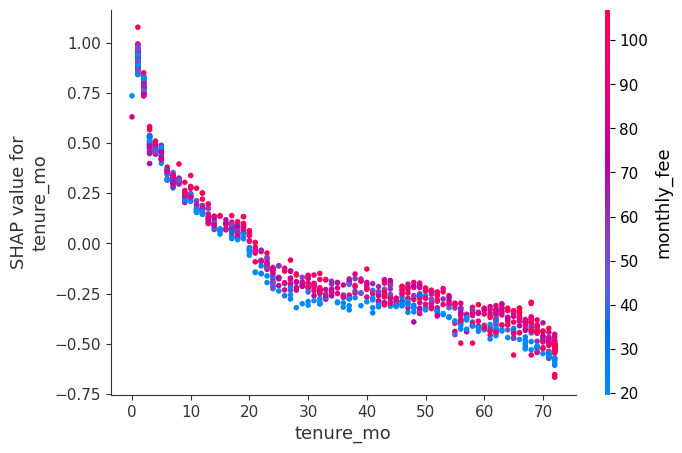

In [ ]:
shap.dependence_plot(
    "tenure_mo",
    shap_values,
    X_shap,
    interaction_index="monthly_fee",
    show=True
)

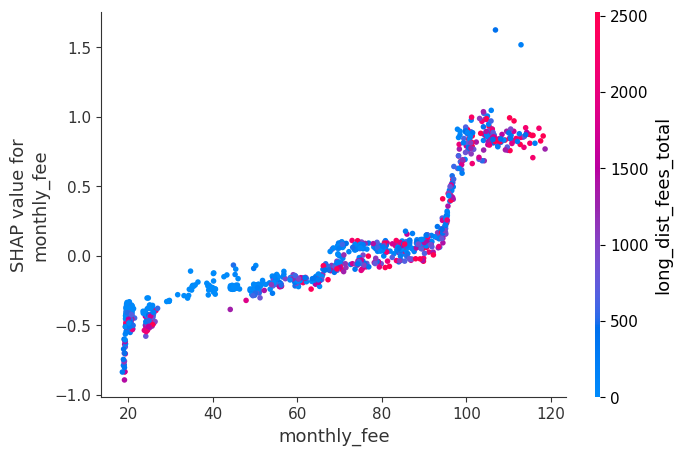

In [ ]:
shap.dependence_plot(
    "monthly_fee",
    shap_values,
    X_shap,
    interaction_index="long_dist_fees_total",
    show=True
)

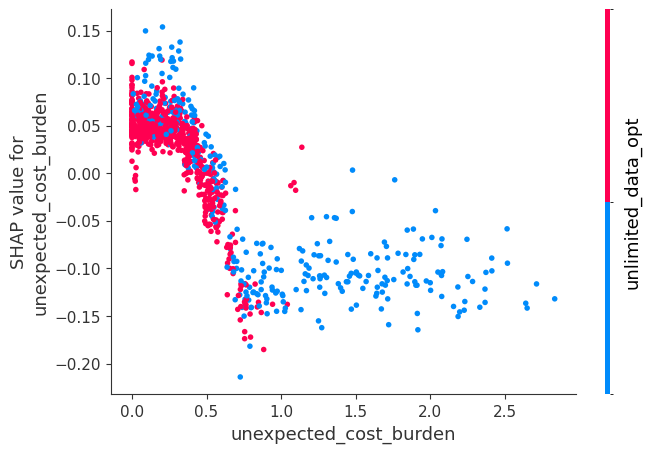

In [ ]:
shap.dependence_plot(
    "unexpected_cost_burden",
    shap_values,
    X_shap,
    interaction_index="unlimited_data_opt",
    show=True
)

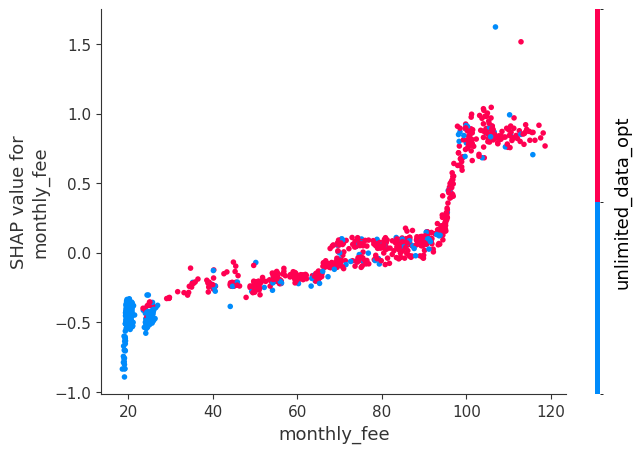

In [ ]:
shap.dependence_plot(
    "monthly_fee",
    shap_values,
    X_shap,
    interaction_index="unlimited_data_opt",
    show=True
)

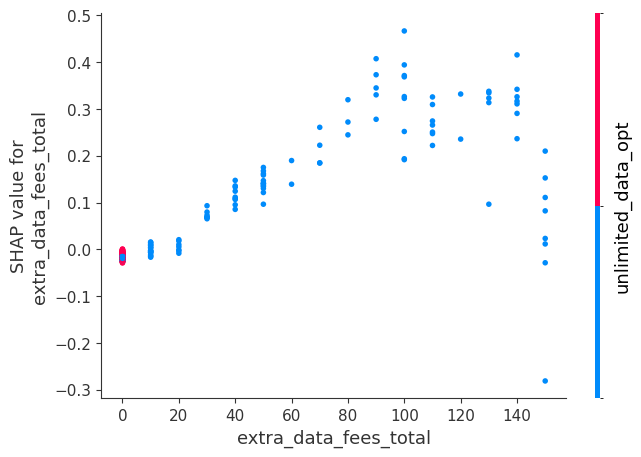

In [ ]:
shap.dependence_plot(
    "extra_data_fees_total",
    shap_values,
    X_shap,
    interaction_index="unlimited_data_opt",
    show=True
)

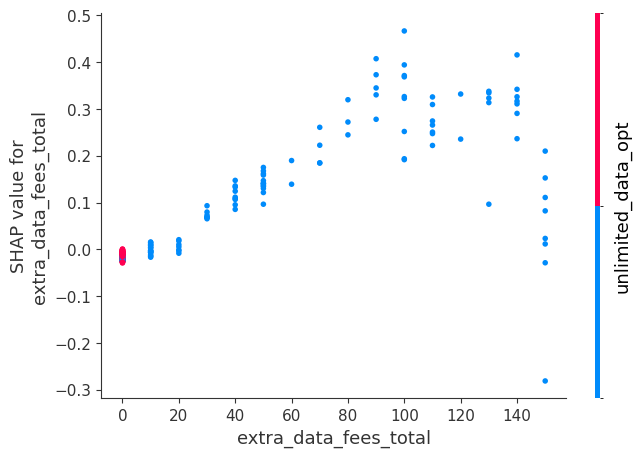

In [ ]:
shap.dependence_plot(
    "extra_data_fees_total",
    shap_values,
    X_shap,
    interaction_index="unlimited_data_opt",
    show=True
)